In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity
from typing import Literal
from sklearn.base import ClusterMixin, BaseEstimator

In [31]:
centroids = np.array([[0, 0], [1, 1]])
x = [
    [1, 1],
    [0, 0],
    [2, 2]
]
# np.min(euclidean_distances(x, centroids) ** 2, axis=1)
# euclidean_distances(x, centroids) ** 2
# np.mean(x, axis=0)
labels = np.array([1, 0, 1, 2, 1])
np.eye(3)[labels]

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

### Implement base KMeans and KMeans++, compare them

In [35]:
class KMeans(BaseEstimator, ClusterMixin):
    def __init__(self, k, max_iter=300, tol=1e-4, random_state=None, 
                 init_method: Literal['random', 'kmeans++']='kmeans++',
                 metric:Literal['euclidean', 'manhattan', 'cosine']='euclidean'):
        self.k = k
        self.random_state = random_state          
        self.max_iter = max_iter
        self.tol = tol    
        self.init_method = init_method        
        self.metric = metric                
          

    def _initialize_centroids(self, X):
        indices = np.arange(X.shape[0])
        if self.init_method == 'random':
            self.cluster_centers_ = X[self.rng.choice(a=indices, size=self.k, replace=False)]        
        elif self.init_method == 'kmeans++':
            self.cluster_centers_ = np.empty((self.k, X.shape[1]))
            self.cluster_centers_[0] = X[self.rng.choice(a=indices)]
            for i in range(1, self.k):            
                distances = self.distance_func_(X, self.cluster_centers_[:i])
                '''
                Each subsequent center is chosen from a probability distribution over the data points, 
                where the probability of selecting a point is proportional to the square of its distance 
                to the nearest already chosen cluster center.
                '''
                min_distances = np.min(distances, axis=1) ** 2
                probabilities = min_distances / np.sum(min_distances) # for x which are already centroids proba is 0                
                self.cluster_centers_[i] = X[self.rng.choice(a=indices, p=probabilities)]            
        else:
            raise ValueError(f'No such init_method, like {self.init_method}')                    
         
    def _assign_clusters(self, X):        
        distances = self.distance_func_(X, self.cluster_centers_)
        return np.argmin(distances, axis=1).flatten()        
        

    def _update_centroids(self, X, labels):
        for i in range(self.k):
            cluster = X[labels == i]
            self.cluster_centers_[i] = np.mean(cluster, axis=0)
            

    def _calculate_inertia(self, X, labels):        
        return np.sum(self.distance_func_(X, self.cluster_centers_)  * np.eye(self.k)[labels]) / X.shape[0]

    def fit(
            self, X, y=None            
            ):
        self.rng = np.random.default_rng(self.random_state)            
        if self.metric == 'euclidean':
            self.distance_func_ = euclidean_distances
        elif self.metric == 'manhattan':
            self.distance_func_ = manhattan_distances
        elif self.metric == 'cosine':
            self.distance_func_ = lambda x, y: 1 - cosine_similarity(x, y)
        else: 
            raise ValueError(f'No such metric, like {self.metric}')                      
        
        self.cluster_centers_ = None   
        self.labels_ = None
        self.inertia_ = float('inf')           
        self._initialize_centroids(X)                


        for _ in range(self.max_iter):
            labels = self._assign_clusters(X)
            self._update_centroids(X, labels)    
            inertia = self._calculate_inertia(X, labels)
            self.labels_ = labels 
            if self.inertia_ - inertia < self.tol:
                self.inertia_ = inertia
                break
            self.inertia_ = inertia
                            
        return self
    def predict(self, X):        
        return self._assign_clusters(X)
    
    def fit_predict(self, X, y = None):
        return super().fit_predict(X, y)
    
    def transform(self, X):
        return self.distance_func_(X, self.cluster_centers_)
    def score(self, X, y=None):
        labels = self.predict(X)
        return -self._calculate_inertia(X, labels)

### Visualize the clusterization on synthetic data with different combinations of hyperparameters

random euclidean
random manhattan
random cosine
kmeans++ euclidean
kmeans++ manhattan
kmeans++ cosine
[<Axes: title={'center': 'init method: random, metric: euclidean'}>
 <Axes: title={'center': 'init method: random, metric: manhattan'}>
 <Axes: title={'center': 'init method: random, metric: cosine'}>
 <Axes: title={'center': 'init method: kmeans++, metric: euclidean'}>
 <Axes: title={'center': 'init method: kmeans++, metric: manhattan'}>
 <Axes: title={'center': 'init method: kmeans++, metric: cosine'}>]


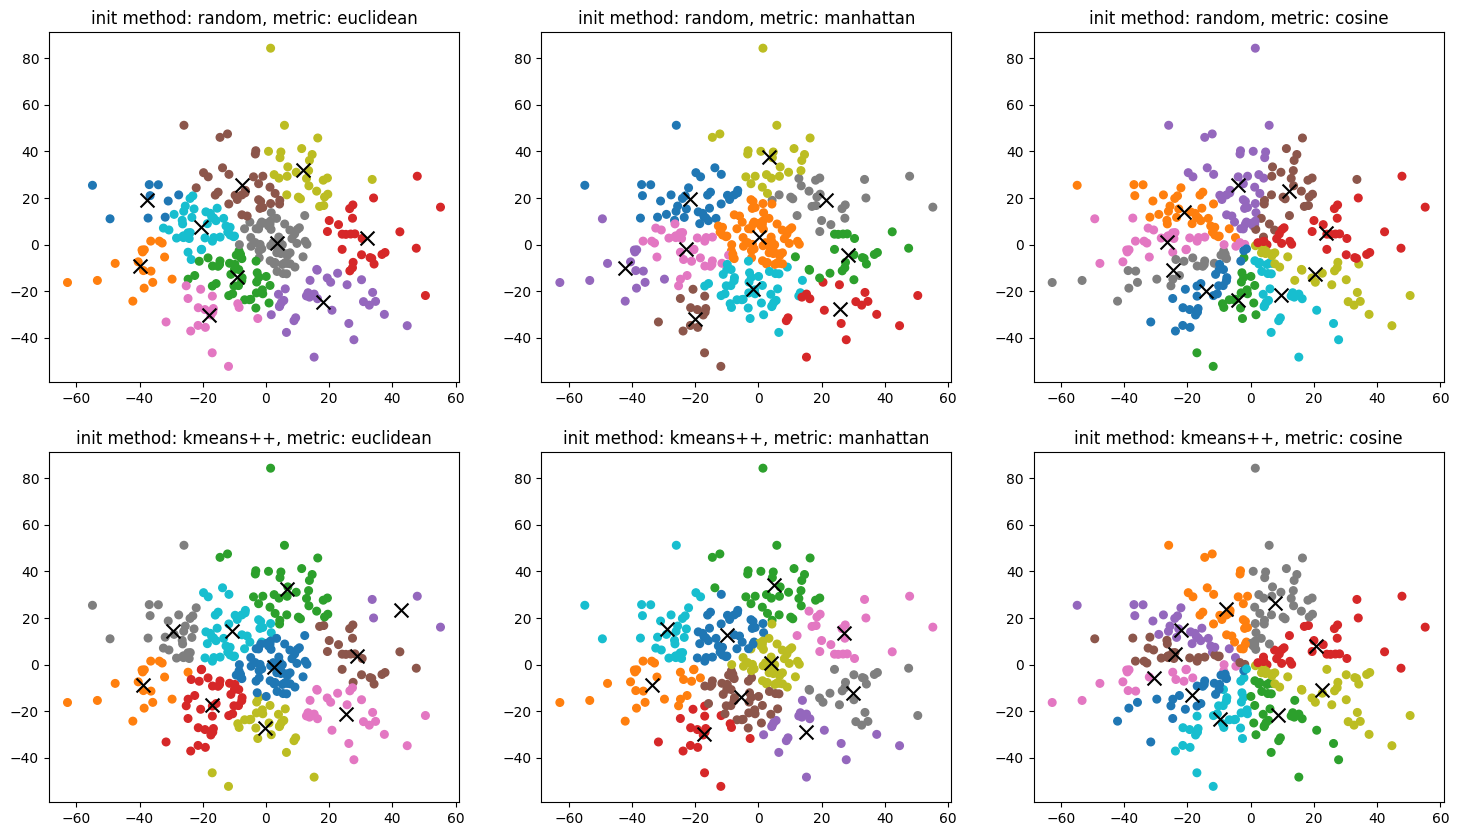

In [45]:
from itertools import product
X, y_true = make_blobs(300, centers=10, cluster_std=20, random_state=42)
init_methods = ['random', 'kmeans++']
metrics = ['euclidean', 'manhattan', 'cosine']
combinations = product(init_methods, metrics)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, (init_method, metric) in enumerate(combinations):
    print(init_method, metric)
    axes[i].set_title(f'init method: {init_method}, metric: {metric}')
    model = KMeans(10, init_method=init_method, metric=metric)
    labels = model.fit_predict(X)
    axes[i].scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10',  s=30)
    axes[i].scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='black', s=100, marker='x')

print(axes) 
